# Predicting Structural Damage from an Earthquake
**-Lhamu Tsering**

In [1]:
# Importing utility functions
import pandas as pd
import numpy as np
import os
import sys
from sklearn.utils import resample

# Importing visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('ggplot')
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix, classification_report

#Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Importing modeling tools
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Importing sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


%load_ext autoreload
%autoreload 2

module_path = os.path.abspath(os.path.join(os.pardir,'src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from nb_modules import model as mod
from nb_modules import eda 
from nb_modules import viz

In [2]:
building_df = pd.read_pickle('../data/pickles/building_df.pkl')

In [3]:
building_df.shape

(762106, 54)

## Feature Engineering

We have a lot of nominal variables that may best be turned to dummies. The corresponding *'num'* features will be added to the drop list to be removed from the main dataset to be used in modeling

In [4]:
dummy_2 = mod.dummify(building_df, 'land_surface_condition')
dummy_3 = mod.dummify(building_df, 'foundation_type')
dummy_4 = mod.dummify(building_df, 'roof_type')
dummy_5 = mod.dummify(building_df, 'ground_floor_type')
dummy_6 = mod.dummify(building_df, 'other_floor_type')
dummy_7 = mod.dummify(building_df, 'position')
dummy_8 = mod.dummify(building_df, 'plan_configuration')
dummy_9 = mod.dummify(building_df, 'legal_ownership_status')

Next, we drop all the features that converted to dummies as the other features from EDA: `has_secondary_use` and `has_geotechnical_risk`.

In [5]:
# defining the list of features to drop
drop_list= ['ward_id', 'land_surface_condition', 'foundation_type',
       'roof_type', 'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration','legal_ownership_status', 'land_surface_condition_num', 
            'foundation_type_num', 'roof_type_num',
       'ground_floor_type_num', 'other_floor_type_num', 'position_num', 
            'plan_configuration_num', 'legal_ownership_status_num', 
            'has_secondary_use', 'has_geotechnical_risk', 'district_id', 'vdcmun_id']
len(drop_list)

21

In [6]:
# dropping the drop_list features
building_df.drop(columns= drop_list, axis=1, inplace=True)

In [7]:
#defining the dataframes to be concatenated and confirming appropriate shape
df_list= [building_df, dummy_2 , dummy_3 , dummy_4 , 
          dummy_5 , dummy_6 , dummy_7 , dummy_8 , dummy_9]
for df in df_list:
    print(df.shape)

(762106, 33)
(762106, 2)
(762106, 4)
(762106, 2)
(762106, 4)
(762106, 3)
(762106, 3)
(762106, 9)
(762106, 3)


In [8]:
# Concatenating all the dfs
X = pd.concat(df_list, axis=1)

# Defining the target variable
y = X['target']

# Defining the features or independent variables by removing the target
X.drop(['target'], axis=1, inplace=True)

#previewing shapes
print(X.shape)
print(y.shape)

(762106, 62)
(762106,)


## Train Test Split
As part of preprocessing for models, the data needs to be split into a train set and a test set. All models will be trained on the train set and tested on the test set to observe how well the model performs as well as to lookout for any overfitting or underfitting.

In [9]:
#performing train-test split on main dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.4)

#checking the shape of the training set and test set
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape,)
print("Test set - Features: ", X_test.shape, "Target: ",y_test.shape,)
print('============================================ ')
print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

Training set - Features:  (457263, 62) Target:  (457263,)
Test set - Features:  (304843, 62) Target:  (304843,)
3    0.603718
1    0.217566
2    0.178716
Name: target, dtype: float64
3    0.60212
1    0.21847
2    0.17941
Name: target, dtype: float64


## Class Imbalance
Going forward to tackle the class imbalance problem in the data, we will use a class weight dictionary to defince the class weight to be used in the models

In [10]:
# title = 'Target variable distribution showing Class Imbalance'
# figname = 'target_variable_class_imbalance'

# viz.target_var(building_df, title, figname, xmax = 762106)

There is some level of class imbalance. 60% of the buildings in the dataset have severe or Grade 3 damage, while about 22% are buildings of Grade 1 with minor damages and 18% of buildings are of Grade 2 or major damages.

To deal with this we will use a composition of downsampling the majority class which is class 3 and upsampling the minority class which is class 2.

In [11]:
#concatenate our training data back together
training = pd.concat([X_train, y_train], axis=1)

# Separating the classes
grade1 = training[training['target']==1]
grade2 = training[training['target']==2]
grade3 = training[training['target']==3]
training['target'].value_counts()

3    276058
1     99485
2     81720
Name: target, dtype: int64

In [12]:
# Downsampling class 3 in reference to length of class 1
downsampled_grade3 = resample(grade3,
                      replace=False,
                      n_samples = len(grade1)+30000,
                      random_state = 100)

downsampled_grade3.shape

(129485, 63)

In order to not lose too much information in reducing the size of class label 3 of the target variable as well as to manage the class imbalance the n_smaples chosen here is the length of class label 1 with a padding of 30000. 

In [13]:
upsample_grade2 = resample(grade2,
                          replace= True,
                          n_samples = len(grade1),
                          random_state = 100)

upsample_grade2.shape

(99485, 63)

In [14]:
resampled = pd.concat([downsampled_grade3, grade1, upsample_grade2])

# viz.target_var_resample(resampled)
resampled['target'].value_counts(normalize=True)

3    0.394224
2    0.302888
1    0.302888
Name: target, dtype: float64

The differences between the classes are much more stable than before.

In [15]:
y_train_resampled = resampled['target']
X_train_resampled = resampled.drop(columns = ['target'], axis= 1)
X_train_resampled.shape

(328455, 62)

The final `X_train_resampled` has 83 features and 328455 observations for training models to.

## Standardizing the train and test sets
Here I used the standard scaler to standardize the datasets.

In [16]:
from sklearn.preprocessing import StandardScaler

columns = X_train_resampled.columns

scaler = StandardScaler()  
scaler.fit(X_train_resampled)

X_train_scaled_values = scaler.transform(X_train_resampled.values)  
X_test_scaled_values = scaler.transform(X_test.values)

X_train_scaled = X_train_resampled.copy()
X_test_scaled = X_test.copy()

X_train_scaled[columns]= X_train_scaled_values
X_test_scaled[columns] = X_test_scaled_values

## Model Iterations
To evaluate the various models, I will rely on the model recall score. The model recall score measures how well the model predicts actual positives, in the hopes of minimizing any False Negatives over False Positives. In reference to the business case, if a building is predicted to not face severe damage when it actually could become severely damaged then such a building may not get the needed reinforcement solutions that it needs to be made safe.

### Logistic Regression Model

In [17]:
scoring = {'recall': mod.scorer_recall()}

In [18]:
# Staging the Logistic Regression model object
lr = LogisticRegression(random_state=100, multi_class='multinomial', solver= 'saga' )

#Defining the parameters to use in the gridsearch
params = {'C':[0.1, 1, 5, 10], 'max_iter': [1000, 10000]}

#Staging the gridsearch 
gs_lr = GridSearchCV(lr, param_grid=params, scoring=scoring, cv=3, verbose=2, refit='recall', n_jobs=-1)

In [20]:
# fitting the grid search to the train sets
gs_lr.fit(X_train_scaled, y_train_resampled)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed: 29.1min finished


KeyboardInterrupt: 

In [21]:
gs_lr.best_params_

{'C': 0.1, 'max_iter': 1000}

In [22]:
lr2 = LogisticRegression(solver='saga',multi_class='multinomial', 
                                random_state=100, max_iter=1000, C=1,
                                verbose=2, n_jobs=-1)

lr2.fit(X_train_scaled, y_train_resampled) 

# class predictions (not predicted probabilities)
y_pred_test = lr2.predict(X_test_scaled)
y_pred_train = lr2.predict(X_train_scaled)

# checking f1 score
print('Test F1 score: ', round(metrics.f1_score(y_test, y_pred_test, average='weighted'),4))
print('Train F1 score: ', round(metrics.f1_score(y_train_resampled, y_pred_train, average='weighted'),4))
print('================================')
# checking recall score
print('Test Recall score: ', round(metrics.recall_score(y_test, y_pred_test, average='weighted'),4))
print('Train Recall score: ', round(metrics.recall_score(y_train_resampled, y_pred_train, average='weighted'),4))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


KeyboardInterrupt: 

In [25]:
mod_eval['lr2']={'f1':0.6734, 'recall': 0.6622}

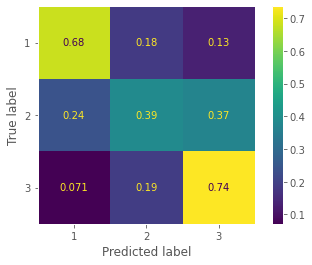

In [26]:
plot_confusion_matrix(lr2, X_train_scaled, y_train_resampled, normalize='true')
plt.grid(False);

The confusion matrix plot for the lr1 model shows that the model was very good at predicting class 3, performed about average in predicting class 1 and did very poorly in predicting class 2.

### Decision Tree Classifier

In [45]:
dtc1 = DecisionTreeClassifier(random_state=100, max_depth= 20)

In [46]:
dtc1.fit(X_train_scaled, y_train_resampled)

y_pred_test= dtc4.predict(X_test_scaled)
y_pred_train = dtc4.predict(X_train_scaled)

# checking f1 score
print('Test F1 score: ', round(metrics.f1_score(y_test, y_pred_test, average='weighted'),4))
print('Train F1 score: ', round(metrics.f1_score(y_train_resampled, y_pred_train, average='weighted'),4))
print('================================')
# checking recall score
print('Test Recall score: ', round(metrics.recall_score(y_test, y_pred_test, average='weighted'),4))
print('Train Recall score: ', round(metrics.recall_score(y_train_resampled, y_pred_train, average='weighted'),4))

Test F1 score:  0.6965
Train F1 score:  0.7583
Test Recall score:  0.6836
Train Recall score:  0.7585


In [47]:
mod_eval['dtc1']={'f1':round(metrics.f1_score(y_test, y_pred_test, average='weighted'),4),
                  'recall': round(metrics.recall_score(y_test, y_pred_test, average='weighted'),4)}
mod_eval

{'baseline_lr1': {'f1': 0.594, 'recall': 0.6732},
 'lr2': {'f1': 0.6734, 'recall': 0.6622},
 'dtc4': {'f1': 0.6965, 'recall': 0.6836},
 'dtc1': {'f1': 0.6965, 'recall': 0.6836}}

The decision tree classifier model performed better than the logistic regression models. The F1 and Recall scores between the train set and the test set are more stable and higher. There are no signs of bias in the model.

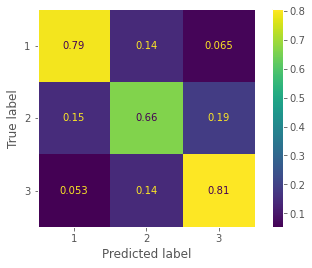

In [48]:
plot_confusion_matrix(dtc1, X_train_scaled, y_train_resampled, normalize='true')
plt.grid(False)

From the confusion matrix too, we see that the model did a better job at predictions overall than the logistic regression model.

<AxesSubplot:title={'center':'Top 15 Important Features'}, ylabel='feature'>

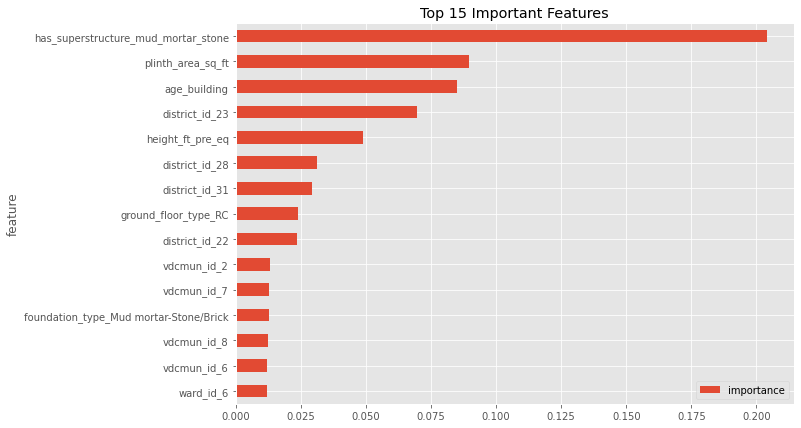

In [49]:
feat_imp = pd.DataFrame({'importance':dtc4.feature_importances_})    
feat_imp['feature'] = X_train_resampled.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[0:15]
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title = 'Top 15 Important Features', figsize=(10,7))


## Decision Tree gridsearch

In [51]:
from sklearn import set_config
set_config(print_changed_only=False)

In [61]:
#setting parameter options
parameters = {'criterion': ['gini', 'entropy'], 'max_depth': range(15, 22,1), 'max_leaf_nodes': range(0,3,1) }

In [62]:
# instantiating estimator
dtc2 = DecisionTreeClassifier(random_state=100)

# Instantiating GridSearch
grid_tree = GridSearchCV(dtc2, parameters,scoring=scoring, cv=10, verbose=2, refit='recall', n_jobs=-1 )

#fit gridsearch to data
grid_tree.fit(X_train_scaled, y_train_resampled)

Fitting 10 folds for each of 42 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   36.9s
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:  1.7min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=100,
                                              splitter='best'),
             iid='deprecated', n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                     

In [59]:
grid_tree.best_params_

{'criterion': 'gini', 'max_depth': 18, 'max_leaf_nodes': 2}

In [63]:
# examine the best model

# Single best score achieved across all params (min_samples_split)
print('best_score', grid_tree.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print('best_param',grid_tree.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print('best_estimator', grid_tree.best_estimator_)

best_score 0.9266092110411623
best_param {'criterion': 'gini', 'max_depth': 15, 'max_leaf_nodes': 2}
best_estimator DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=15, max_features=None, max_leaf_nodes=2,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=100, splitter='best')


In [64]:
y_pred_test= grid_tree.best_estimator_.predict(X_test_scaled)
y_pred_train = grid_tree.best_estimator_.predict(X_train_scaled)

# checking f1 score
print('Test F1 score: ', round(metrics.f1_score(y_test, y_pred_test, average='weighted'),4))
print('Train F1 score: ', round(metrics.f1_score(y_train_resampled, y_pred_train, average='weighted'),4))
print('================================')
# checking recall score
print('Test Recall score: ', round(metrics.recall_score(y_test, y_pred_test, average='weighted'),4))
print('Train Recall score: ', round(metrics.recall_score(y_train_resampled, y_pred_train, average='weighted'),4))

Test F1 score:  0.6047
Train F1 score:  0.4337
Test Recall score:  0.6782
Train Recall score:  0.532


In [65]:
mod_eval['dtc2']={'f1':round(metrics.f1_score(y_test, y_pred_test, average='weighted'),4),
                  'recall': round(metrics.recall_score(y_test, y_pred_test, average='weighted'),4)}
mod_eval

{'baseline_lr1': {'f1': 0.594, 'recall': 0.6732},
 'lr2': {'f1': 0.6734, 'recall': 0.6622},
 'dtc4': {'f1': 0.6965, 'recall': 0.6836},
 'dtc1': {'f1': 0.6965, 'recall': 0.6836},
 'dtc2': {'f1': 0.6047, 'recall': 0.6782}}